## EDA and Preprocessing

* In this file we will draw insight from the data, engineer the given features and create a table ready for modeling.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf #for stock data
from IPython.display import display #for displaying the full dataframes
import matplotlib.pyplot as plt #for data visualization
import seaborn as sns #for advanced data visualization
import datetime 
import random
from sklearn import preprocessing #for ML models and data processing
import itertools  #advanced tools for loops
import math #for mathematical tools
from sklearn.preprocessing import StandardScaler
sns.set(style="darkgrid") #set theme

%matplotlib inline

In [2]:
dt = pd.read_excel (r'data_clean.xlsx')

#separate train\test
train_count = round(len(dt)*0.8)
train = dt.sample(train_count,random_state = 54)
test = pd.concat([dt, train, train]).drop_duplicates(keep=False)

train['train']=1
test['train']=0
dt = pd.concat([test,train]).sort_index()


### 1) Outcome:

represents the trade outcome: 

* 'BE' - breakeven trade
* 'WINNER' - winner trade
* 'LOSER' - loser trade

Add dummy variables for the eda and modeling.

In [3]:

#change the WiNNER, BE, and LOSER features to dummy variables
dt['is_winner'] = dt['Outcome'].apply(lambda x: 1 if x=='WINNER' else 0 )
dt['is_be'] = dt['Outcome'].apply(lambda x: 1 if x=='BE' else 0 )
dt['is_loser'] = dt['Outcome'].apply(lambda x: 1 if x=='LOSER' else 0 )

### 2) Entry Price (Intended Entry):

Is there a favourable price?

Note that I am using Intended Entry because 'Entry Price' is the excecution price, meaning it may 

be affected by price volatility and high spreads, whereas 'Intended Entry' is simply the planned entry price and

is not influenced by any of those.

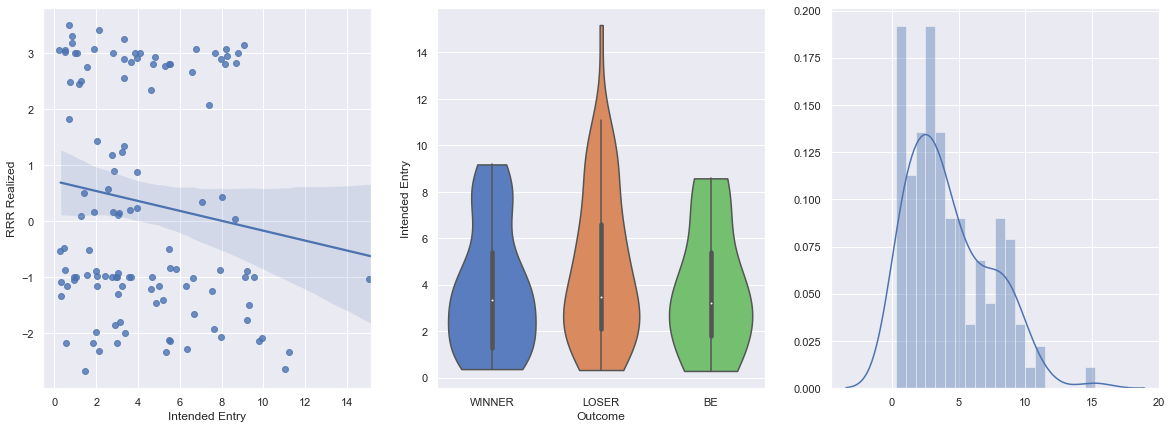

In [4]:
train = dt[dt['train']==1]

# get subset of train
train2 = train[['Intended Entry','Outcome', 'RRR Realized']].copy()


fig,ax = plt.subplots(1,3 ,figsize = (20,7))


ax[0] = sns.regplot(x="Intended Entry", y="RRR Realized", data=train2,ax = ax[0],x_jitter=.2)


ax[1] = sns.violinplot(x="Outcome", y="Intended Entry",data=train2, palette="muted",cut = 0,ax = ax[1])

ax[2] = sns.distplot(a=train2[['Intended Entry']],bins = 20,ax = ax[2])



([<matplotlib.axis.XTick at 0x2214e64e2e0>,
 [Text(0, 0, '- 0.5'),
  Text(0, 0, '0.5 - 6'),
  Text(0, 0, '6 - 10'),
  Text(0, 0, '10 -')])

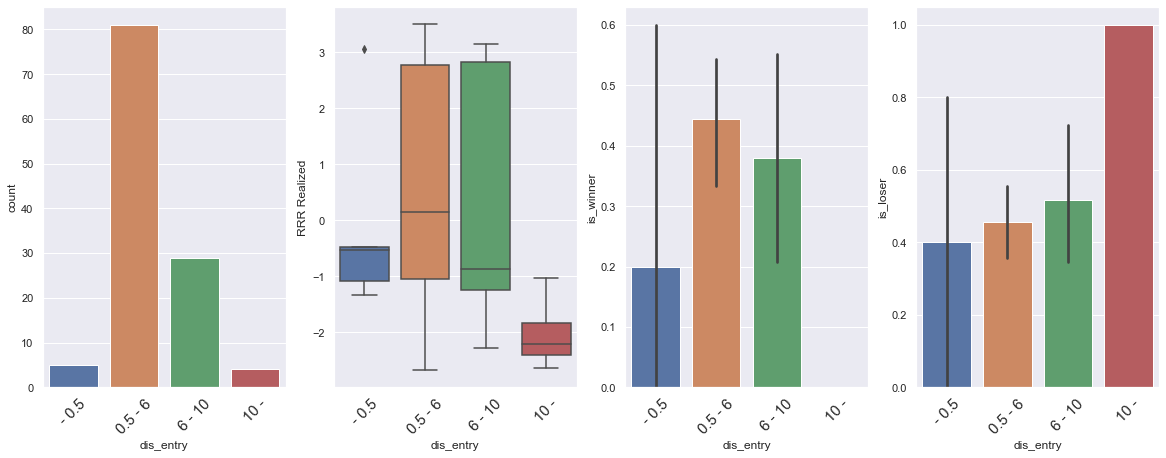

In [5]:

def replaceEntry(price):
    if price<0.5:
        price = 1
    elif price<6:
        price = 2
    elif price<10:
        price = 3
    else:
        price = 4
    return price

dis_val=["- 0.5","0.5 - 6","6 - 10","10 -"]

# create a new column with the discretized intended entry prices
dt['dis_entry'] = dt['Intended Entry'].apply(replaceEntry)

train = dt[dt['train']==1]        
     

#plot 1

f,axes=plt.subplots(1,4 ,figsize = (20,7))
g = sns.countplot(x="dis_entry",data=train,ax=axes[0])
plt.sca(axes[0])
plt.xticks([0,1,2,3], dis_val,rotation=45,fontsize=15)
      
#plot 2
g = sns.boxplot(x="dis_entry", y="RRR Realized", data=train,ax=axes[1])
plt.sca(axes[1])
plt.xticks([0,1,2,3], dis_val,rotation=45,fontsize=15)

#plot 3
g= sns.barplot(x="dis_entry",y="is_winner",data=train,ax = axes[2])
#g= g.set_ylabels("Winning Probability")
plt.sca(axes[2])
plt.xticks([0,1,2,3], dis_val,rotation=45,fontsize=15)

#plot 4
g= sns.barplot(x="dis_entry",y="is_loser",data=train,ax = axes[3])
plt.sca(axes[3])
plt.xticks([0,1,2,3], dis_val,rotation=45,fontsize=15)

##### Inference:
* Trades with stocks above \\$10 and under \\$0.5 tend to be less favourable.


* Trades  within the ranges: \\$0.5-\\$5 and \\$7-\\$9 potentially have the best outcome.


* The left plot shows a negative correlation, although there is high variance and low bias.


* The data is has noise and is slightly skewed


therefore I decided to group the price data to 4 groups: 0-0.5, 0.5-6,6-10,10- with the bins 1,2,3 and 4 respectively.

Another things to note that there aren't many observations around the unfavourable values.

### 3) Sector:

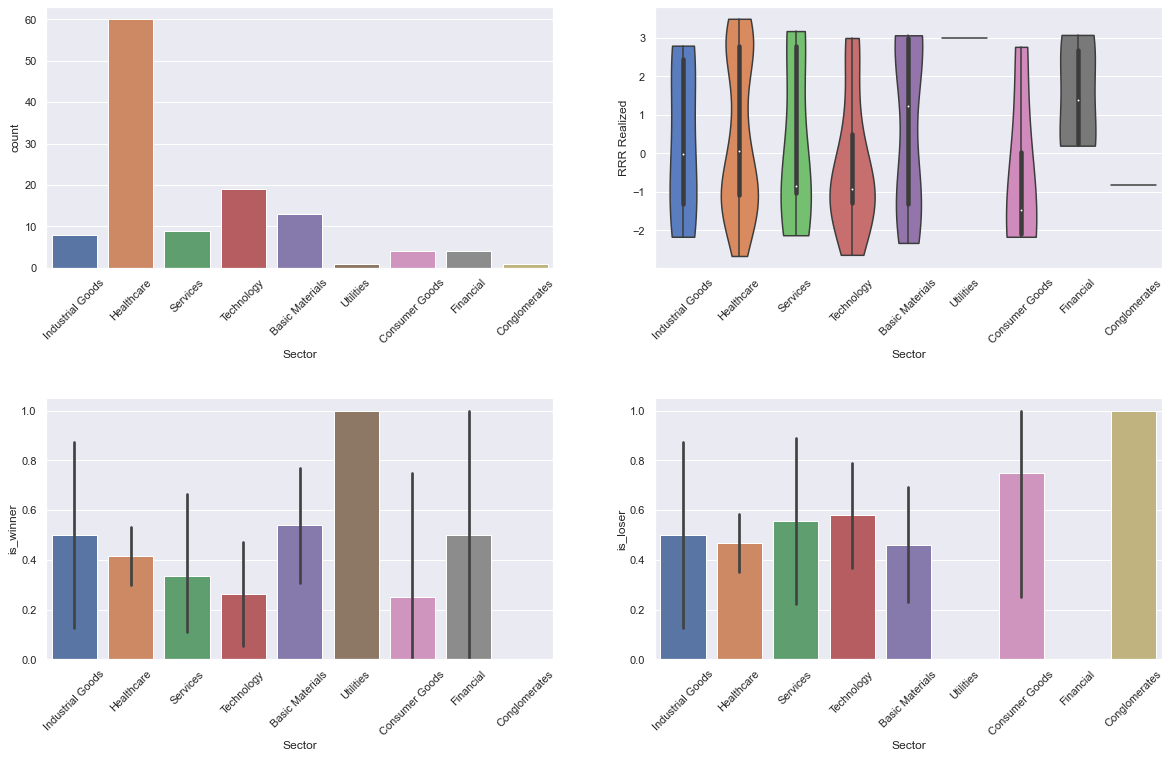

In [6]:


#plot 1
f,axes=plt.subplots(2,2,figsize=(20,12))
g1 = sns.countplot(x="Sector",data=train,ax=axes[0,0])
f.subplots_adjust(hspace=0.5)
axes[0,0].tick_params(axis='x',labelrotation=45)


#plot 2
g3 =sns.violinplot(x="Sector", y="RRR Realized", data=train, palette="muted",cut = 0,ax=axes[0,1])
plt.xticks(rotation=45)
axes[0,1].tick_params(axis='x',labelrotation=45)

#plot 3
g2= sns.barplot(x="Sector",y="is_winner",data=train,ax=axes[1,0])
axes[1,0].tick_params(axis='x',labelrotation=45)

#plot 4
g2= sns.barplot(x="Sector",y="is_loser",data=train,ax=axes[1,1])
axes[1,1].tick_params(axis='x',labelrotation=45)



#### Inference:

Since the count of each sector excluding 'Healthcare' is low, (under 20) we see a high obvious variance within the winning probability and 'RRR Realized'. Unfortunately with such results it is difficult to determine whether there is an affect on the trades outcome.

### 4) Pattern:


The 'Pattern' abbreveations represent the technichal pattern which appeared prior to the breakout and trade entry.
I would like to see if there's perhaps a favourable pattern. Recap:

ST = symmetrical triangle

R = rectangle

DT = descending triangle

AT = ascending triangle

P = pennant

F = flag



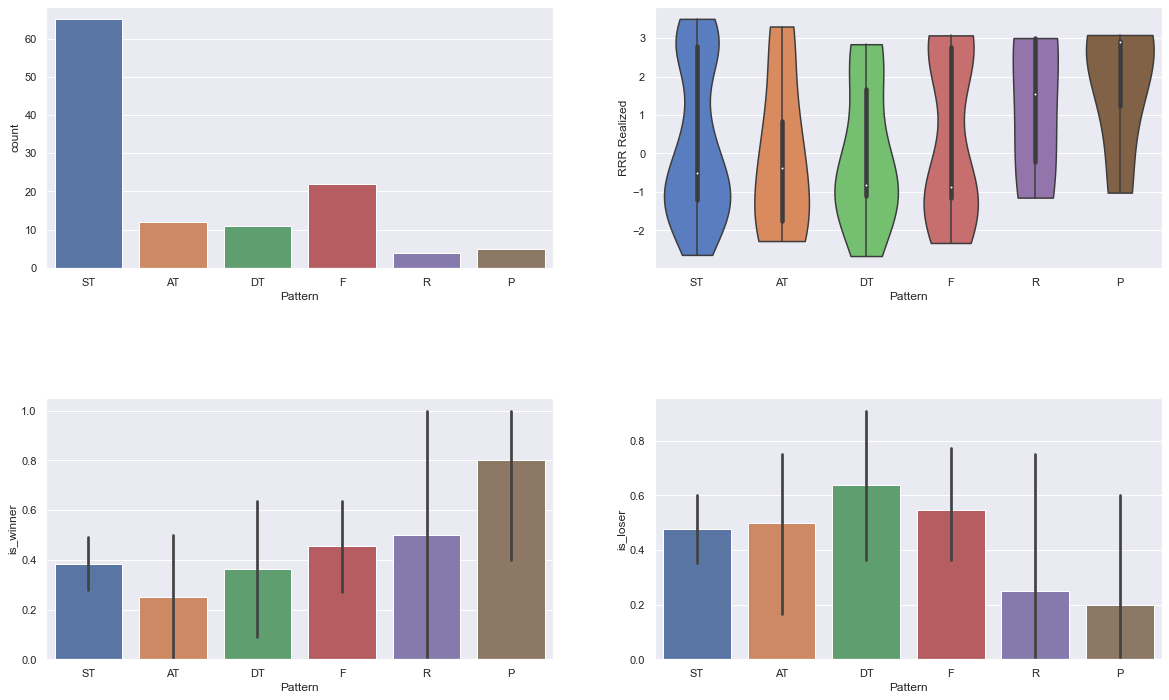

In [7]:



#plot 1
f,axes=plt.subplots(2,2,figsize=(20,12))
g1 = sns.countplot(x="Pattern",data=train,ax=axes[0,0])
f.subplots_adjust(hspace=0.5)



#plot 2
g3 =sns.violinplot(x="Pattern", y="RRR Realized", data=train, palette="muted",cut = 0,ax=axes[0,1])



#plot 3
g2= sns.barplot(x="Pattern",y="is_winner",data=train,ax=axes[1,0])


#plot 4
g2= sns.barplot(x="Pattern",y="is_loser",data=train,ax=axes[1,1])



#### Inference:

* 'F' has the most favourable probability which is just above 0.4, the next are 'AT' and 'DT' with about 0.35 and the last is 'ST' with just over 0.2.

* The results for 'R and 'P' cannot be taken seriously due to their low count.

### 5) Float
* 'Float' has many outliers on both sides. For example there are float values below 1 and above 500 in the data, to address the problem I will use log with base 10 to potentially reduce skewness, and to avoid negative values I will simply change the values under 1 to 1 (there aren't many so it won't make much of a difference).
* There are 3 missing values that need to be imputed.

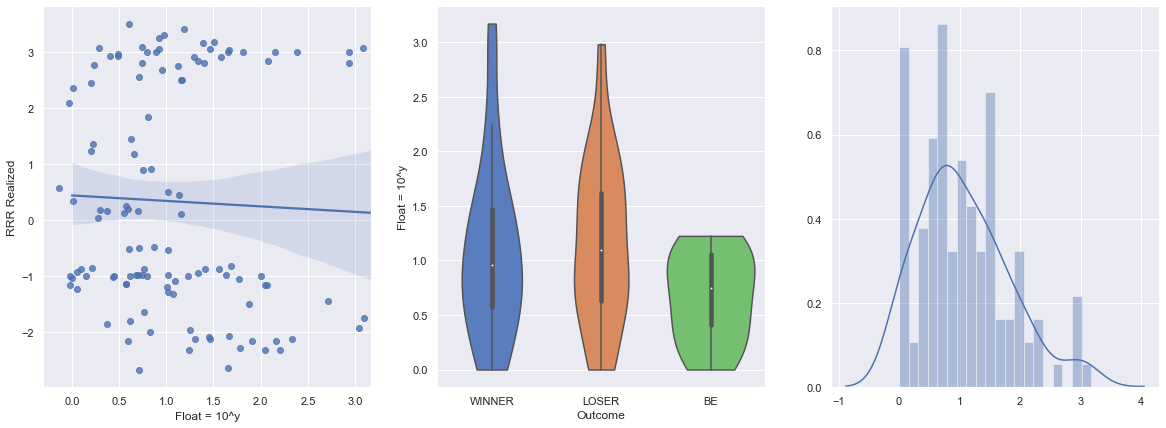

In [8]:


train5 = train.copy()

#change values below 1 to 1
train5['Float'] = train5['Float'].apply(lambda x: 1 if x<1 else x)

# log(x)
train5['Float'] = train5['Float'].apply(lambda x: math.log(x, 10))




fig,ax = plt.subplots(1,3 ,figsize = (20,7))


ax[0] = sns.regplot(x="Float", y="RRR Realized", data=train5,ax = ax[0],x_jitter=.2)

ax[1] = sns.violinplot(x="Outcome", y="Float",data=train5, palette="muted",cut = 0,ax = ax[1])

plt.setp(ax[0], xlabel = "Float = 10^y")
plt.setp(ax[1], ylabel = "Float = 10^y")

ax[2] = sns.distplot(a=train5[["Float"]],bins = 20,ax = ax[2])

#### Inference: 
It is very difficult to draw conclusions, also here the variance is very high and no bias. Perhaps qualitative variables will perform better. A standard form of distinguishing floats is: 0-1, 1-8, 8-15, 15-30, 30 -, I'll use bins 1,2,3,4 and 5 to present them respectively.





([<matplotlib.axis.XTick at 0x2214f61eeb0>,
 [Text(0, 0, '0-1'),
  Text(0, 0, '1-8'),
  Text(0, 0, '8-15'),
  Text(0, 0, '15-30'),
  Text(0, 0, '30-')])

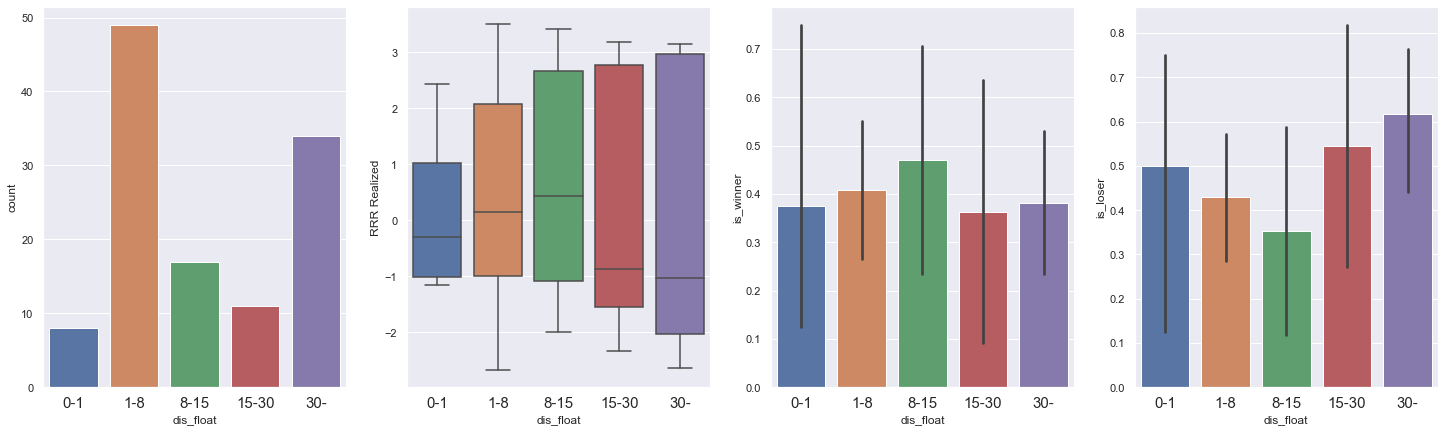

In [9]:

def replaceFloat(f):
    if f< 1:
        f = 1
    elif f < 8:
        f = 2
    elif f < 15:
        f = 3
    elif f < 30:
        f = 4
    else:
        f = 5
    return f

dis_val = ["0-1","1-8","8-15","15-30","30-"]
# create a new column with the discretized intended entry prices
dt['dis_float'] = dt['Float'].apply(replaceFloat)
train = dt[dt['train']==1]    





#plot 1

f,axes=plt.subplots(1,4 ,figsize = (25,7))
g = sns.countplot(x="dis_float",data=train,ax=axes[0])
plt.sca(axes[0])
plt.xticks([0,1,2,3,4], dis_val,fontsize=15)
      
#plot 2
g = sns.boxplot(x="dis_float", y="RRR Realized", data=train,ax=axes[1])
plt.sca(axes[1])
plt.xticks([0,1,2,3,4], dis_val,fontsize=15)

#plot 3
g= sns.barplot(x="dis_float",y="is_winner",data=train,ax = axes[2])
plt.sca(axes[2])
plt.xticks([0,1,2,3,4], dis_val,fontsize=15)

#plot 4
g= sns.barplot(x="dis_float",y="is_loser",data=train,ax = axes[3])
plt.sca(axes[3])
plt.xticks([0,1,2,3,4], dis_val,fontsize=15)


#### Inference:
Best performers are:

* float range 1-8

* float range 8-15




In [10]:
# fill NaN values with the average float of the [x-1,x+1] range
# where x is the 'Intended Entry' of the row with the missing float 
# update dis_float 


for index,row in dt.iterrows():
    current_float = row['Float']
    current_price = row['Intended Entry']
    
    if np.isnan(current_float): 
        reduced_dt = dt[(dt['Intended Entry']<(1+current_price)) & (dt['Intended Entry']>(1-current_price))]
        float_average =  reduced_dt['Float'].mean()         
        dt.loc[index, 'Float'] = float_average
        dt.loc[index, 'dis_float'] = replaceFloat(float_average)




### 6) Catalyst:

Catalyst is detemined by what is moving the stock price?

* L - leading secotr
* H - hype for reasons unknown
* C - catalyst that come from news of some sort e.g. FDA approval of a drug or good earnings

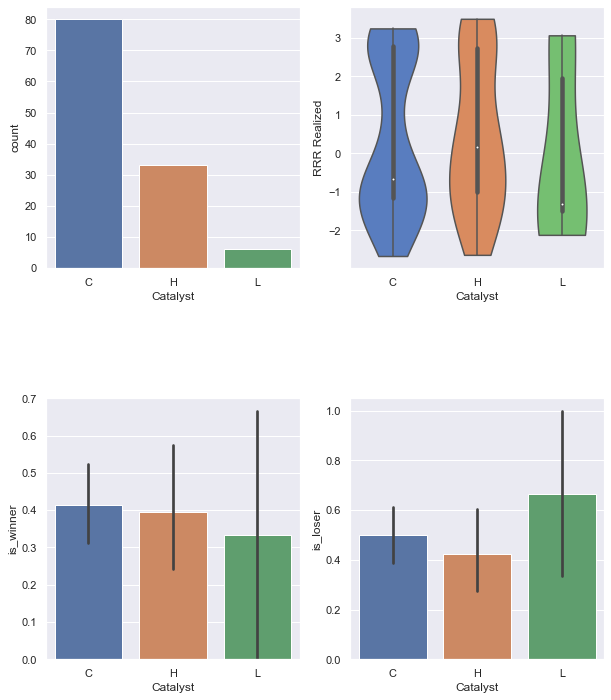

In [11]:
train = dt[dt['train']==1]

#plot 1
f,axes=plt.subplots(2,2,figsize=(10,12))
g1 = sns.countplot(x="Catalyst",data=train,ax=axes[0,0])
f.subplots_adjust(hspace=0.5)



#plot 2
g3 =sns.violinplot(x="Catalyst", y="RRR Realized", data=train, palette="muted",cut = 0,ax=axes[0,1])



#plot 3
g2= sns.barplot(x="Catalyst",y="is_winner",data=train,ax=axes[1,0])


#plot 4
g2= sns.barplot(x="Catalyst",y="is_loser",data=train,ax=axes[1,1])

### 7) Pause Num:

Price tend to move in stanges, drive -> correction (pause) -> drive -> correction etc.
The trade is normally take at the breakout of the correction, so the pause num is simply the number of correction the trade took off from.


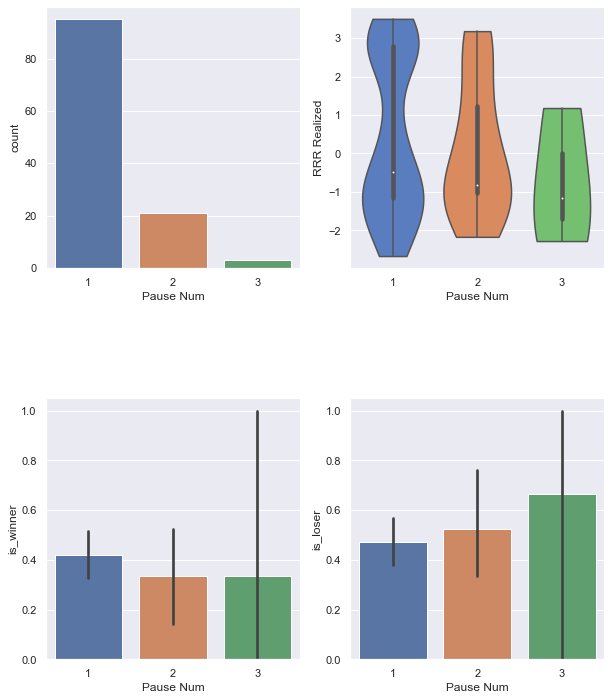

In [12]:


#plot 1
f,axes=plt.subplots(2,2,figsize=(10,12))
g1 = sns.countplot(x="Pause Num",data=train,ax=axes[0,0])
f.subplots_adjust(hspace=0.5)



#plot 2
g3 =sns.violinplot(x="Pause Num", y="RRR Realized", data=train, palette="muted",cut = 0,ax=axes[0,1])



#plot 3
g2= sns.barplot(x="Pause Num",y="is_winner",data=train,ax=axes[1,0])


#plot 4
g2= sns.barplot(x="Pause Num",y="is_loser",data=train,ax=axes[1,1])

#### Inference:
* 'Pause Num' with 3 and above should be avoided

* 'Pause Num' 1 is the most preferable

### 8) VWAP Tag:

This is a tag used for how the technical pattern (correction) of the trade is positioned relative to the vwap and how did the price breakout given that position.

* BO - the pattern is close to the vwap and the price broke out of the pattern and vwap at the same time.
* SUPPORT - the pattern is close to the vwap but at the price was already above vwap prior and after the breakout.
* FALSE - the pattern is positioned away from vwap.

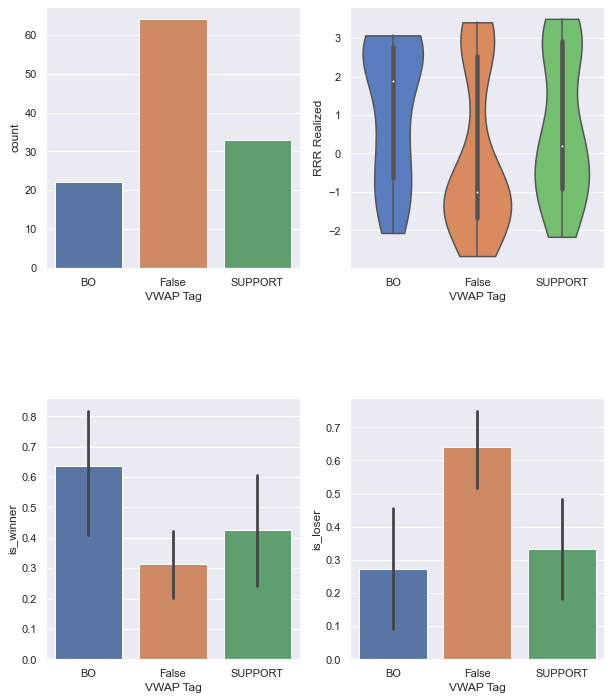

In [13]:


#plot 1
f,axes=plt.subplots(2,2,figsize=(10,12))
g1 = sns.countplot(x="VWAP Tag",data=train,ax=axes[0,0])
f.subplots_adjust(hspace=0.5)



#plot 2
g3 =sns.violinplot(x="VWAP Tag", y="RRR Realized", data=train, palette="muted",cut = 0,ax=axes[0,1])



#plot 3
g2= sns.barplot(x="VWAP Tag",y="is_winner",data=train,ax=axes[1,0])


#plot 4
g2= sns.barplot(x="VWAP Tag",y="is_loser",data=train,ax=axes[1,1])

#### Inference:

* Having a vwap tag shows positive results with BO demonstrating the best results
.

### 9) Gap

The percent gap of the stock on the given day.

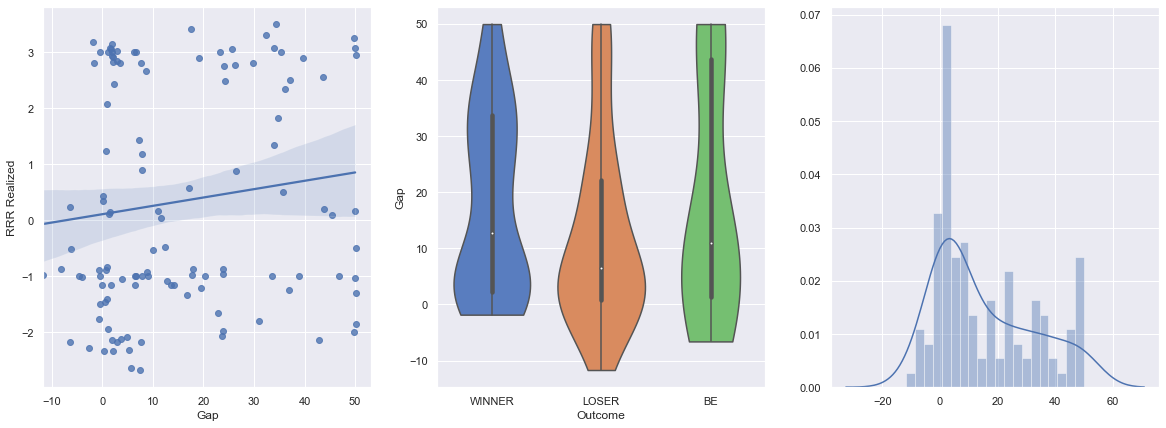

In [14]:



# there are several observations above 50 and within the 50-200 range, 
# due to their low count I decided to convert them to 50, to avoid high leverage points.
dt['Gap'] = dt['Gap'].apply(lambda x: 50 if x>50 else x )


train = dt[dt['train']==1]
fig,ax = plt.subplots(1,3 ,figsize = (20,7))


ax[0] = sns.regplot(x="Gap", y="RRR Realized", data=train,ax = ax[0],x_jitter=.2)

ax[1] = sns.violinplot(x="Outcome", y="Gap",data=train, palette="muted",cut = 0,ax = ax[1])

ax[2] = sns.distplot(a=train[["Gap"]],bins = 20,ax = ax[2])

x = dt[['Gap']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dt['norm_gap'] = pd.DataFrame(x_scaled)



#### Inference:
* There seems to be an underperformace of trades with a gap under 0, unfortunately the number of observation supporting it is low. 
* Focusing on gaps with a big range span above 0 may deliver better results.

### 10) SP500 Change (gap, weekly, monthly and 3 months)

* SPY gap percent change (same as featured above but with the SPY)
* SPY weekly,monthly and 3 months percent change


Smooth the continues features with binning using equal-frequency histogram (5 bins).

for SPY Gap bin 1: min= -1.970000 and max= -0.370000
for SPY Gap bin 2: min= -0.320000 and max= -0.000000
for SPY Gap bin 3: min= -0.000000 and max= 0.190000
for SPY Gap bin 4: min= 0.240000 and max= 0.470000
for SPY Gap bin 5: min= 0.570000 and max= 1.380000
for SPY Week Change bin 1: min= -7.490000 and max= -1.380000
for SPY Week Change bin 2: min= -1.230000 and max= 0.170000
for SPY Week Change bin 3: min= 0.200000 and max= 0.850000
for SPY Week Change bin 4: min= 0.850000 and max= 1.460000
for SPY Week Change bin 5: min= 1.550000 and max= 5.520000
for SPY Month Change bin 1: min= -11.930000 and max= -2.750000
for SPY Month Change bin 2: min= -2.670000 and max= 1.510000
for SPY Month Change bin 3: min= 1.530000 and max= 3.550000
for SPY Month Change bin 4: min= 3.730000 and max= 5.760000
for SPY Month Change bin 5: min= 5.760000 and max= 7.980000
for SPY 3 Month Change bin 1: min= -18.600000 and max= -1.200000
for SPY 3 Month Change bin 2: min= -0.970000 and max= 1.790000
for SPY 3 

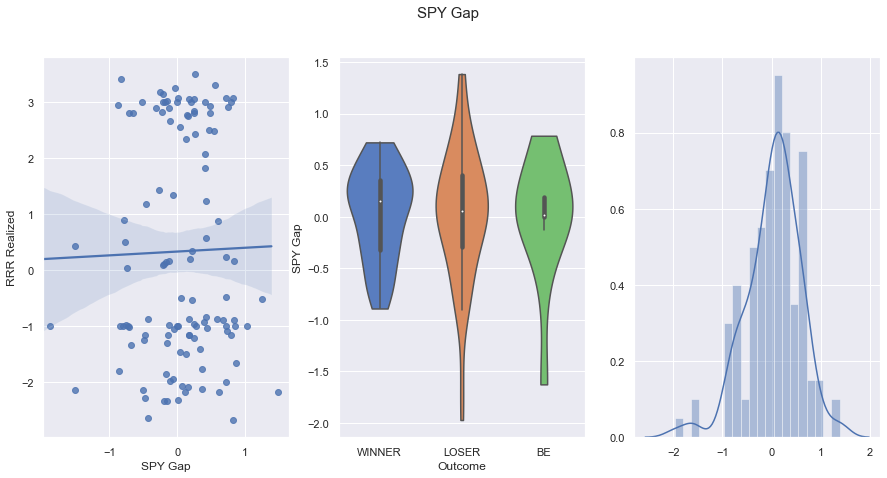

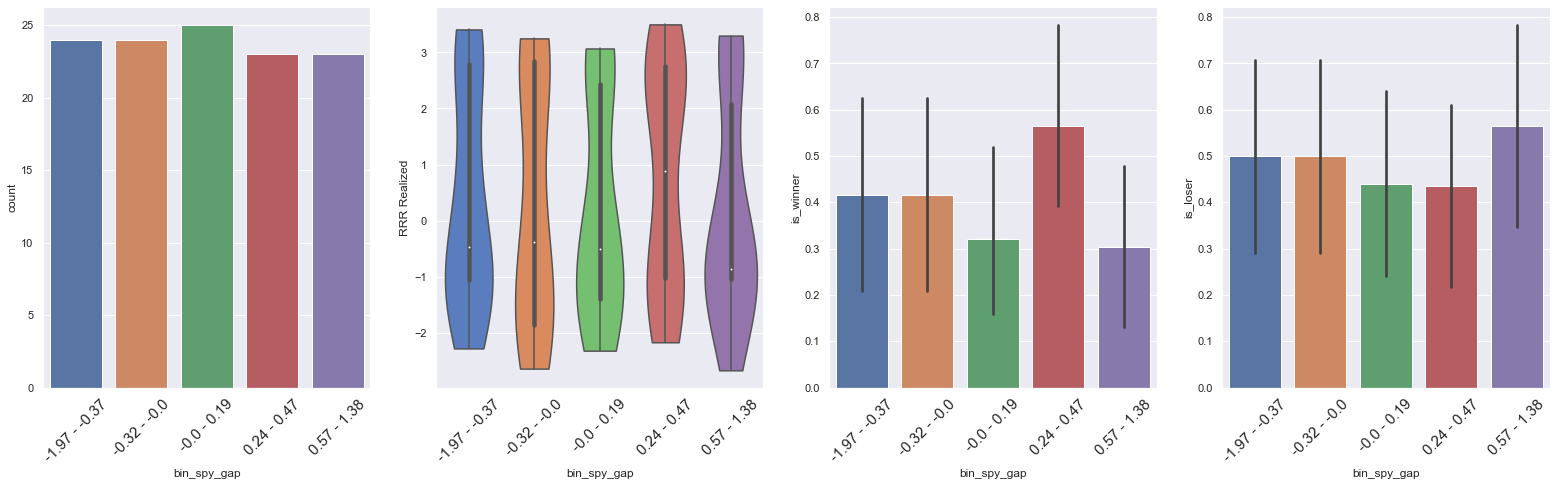

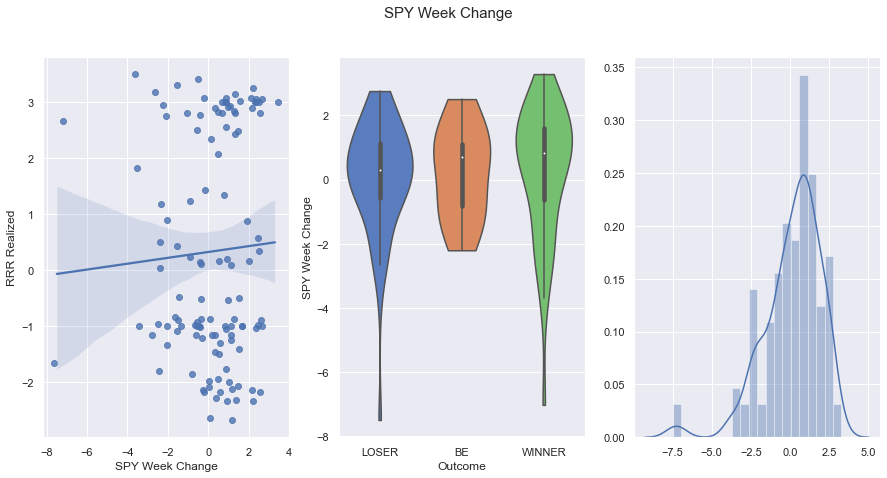

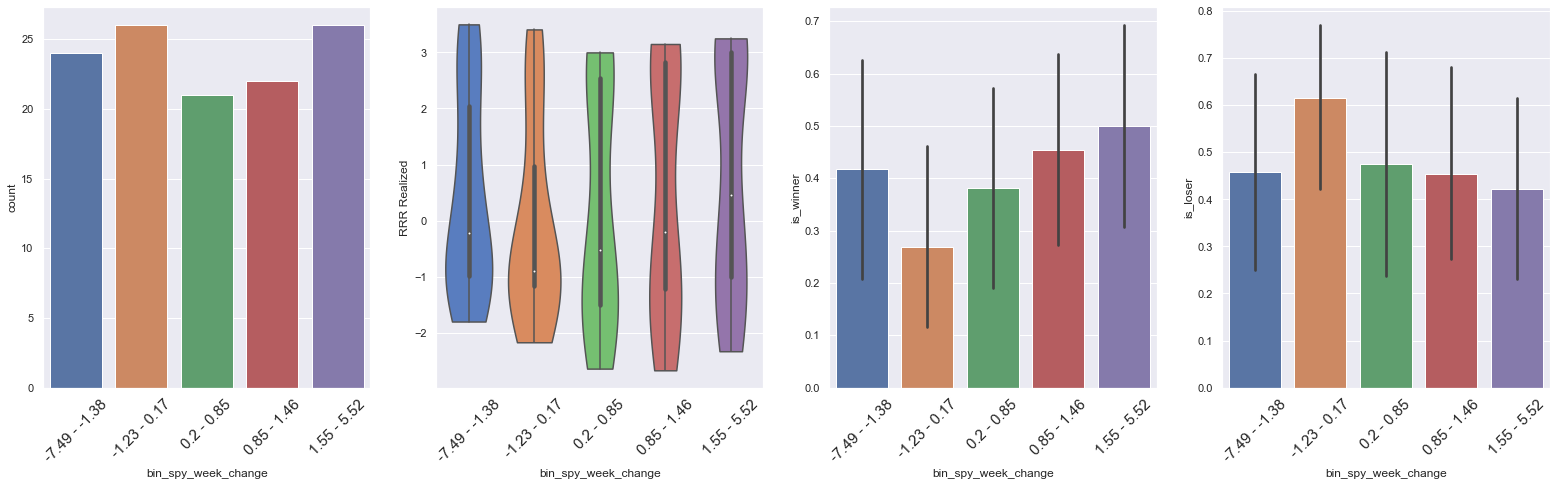

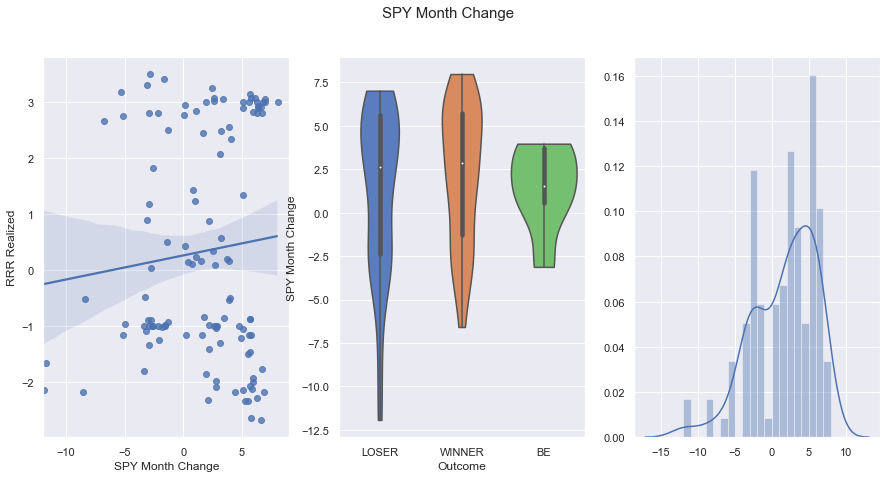

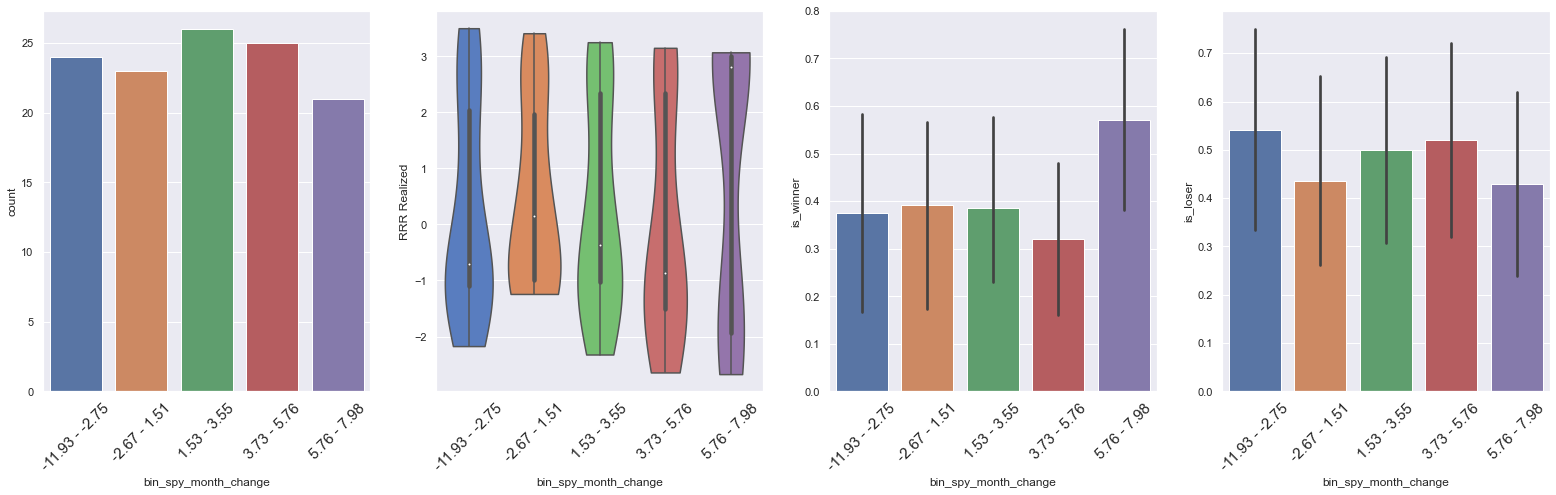

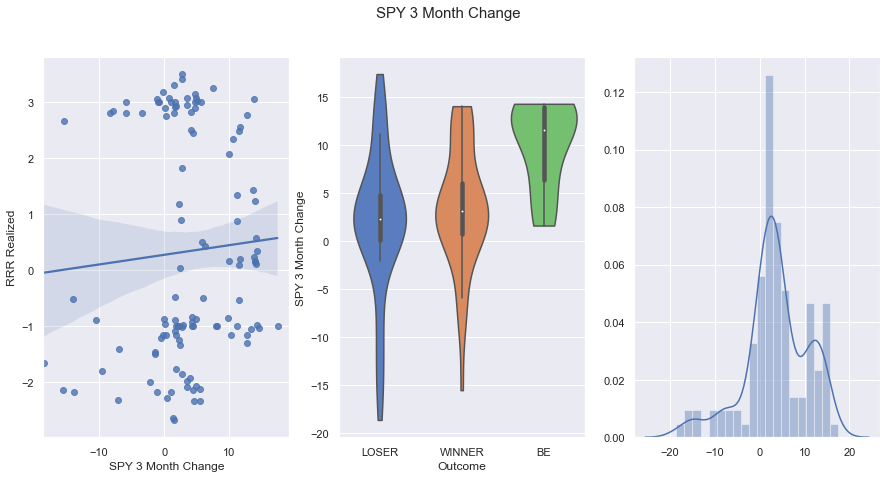

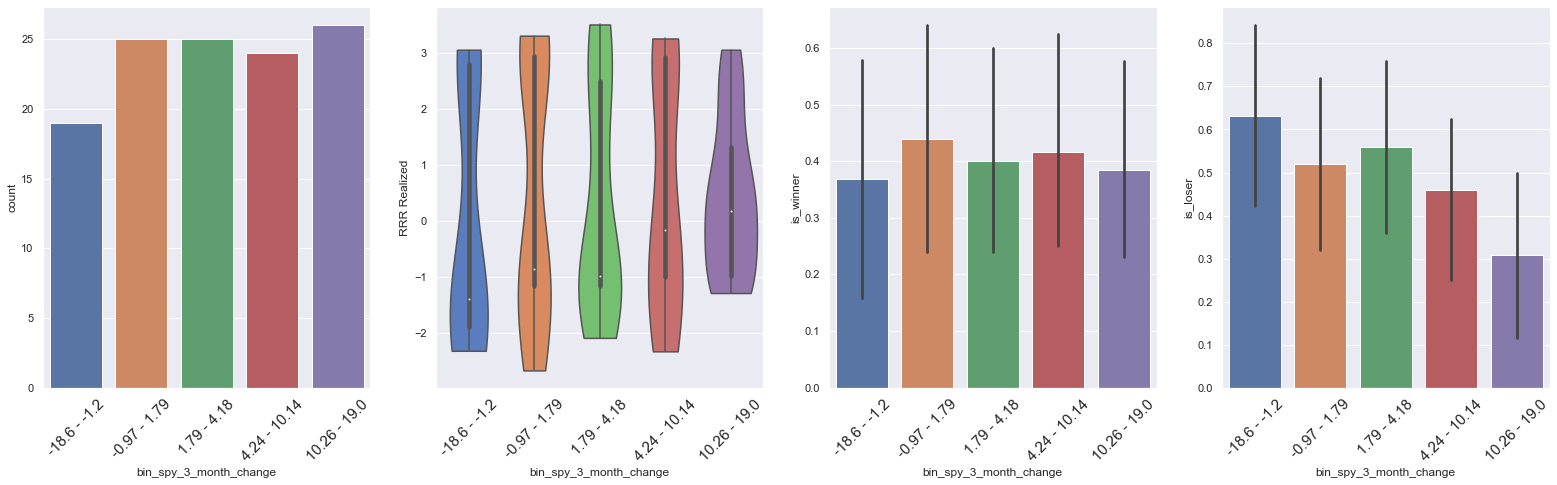

In [15]:

for c in ['SPY Gap','SPY Week Change','SPY Month Change','SPY 3 Month Change']:
    

    fig,ax = plt.subplots(1,3 ,figsize = (15,7))
    fig.suptitle(c, size =15)
    ax[0] = sns.regplot(x=c, y="RRR Realized", data=train,ax = ax[0],x_jitter=.2)
    ax[1] = sns.violinplot(x="Outcome", y=c,data=train, palette="muted",cut = 0,ax = ax[1])
    ax[2] = sns.distplot(a=train[[c]],bins = 20,ax = ax[2])
    
    # binning    
    name = c.lower().replace(' ','_')
    dt["bin_"+name]=0
    dt = dt.sort_values(by = [c])
    dt_arr =  np.array_split(dt,5)
    dis_val=[]
    for i in range(len(dt_arr)):
        dt_arr[i]["bin_"+name] = i+1      
        first=round(dt_arr[i][c].iloc[0],2)
        last=round(dt_arr[i][c].iloc[-1],2)
        dis_val.append(str(first)+" - "+str(last))
        print("for "+ c + " bin %d: min= %f and max= %f"%(dt_arr[i]["bin_"+name].iloc[0],first,last))


    dt = pd.concat(dt_arr)
    
    train = dt[dt['train']==1]
    
    #plot 1
    f,axes=plt.subplots(1,4,figsize=(27,7))
    f.subplots_adjust(hspace=0.5)
    g1 = sns.countplot(x="bin_"+name,data=train,ax=axes[0])
    plt.sca(axes[0])
    plt.xticks([0,1,2,3,4], dis_val,rotation=45,fontsize=15)



    #plot 2
    g3 =sns.violinplot(x="bin_"+name, y="RRR Realized", data=train, palette="muted",cut = 0,ax=axes[1])

    plt.sca(axes[1])
    plt.xticks([0,1,2,3,4], dis_val,rotation=45,fontsize=15)


    #plot 3
    g2= sns.barplot(x="bin_"+name,y="is_winner",data=train,ax=axes[2])
    plt.sca(axes[2])
    plt.xticks([0,1,2,3,4], dis_val,rotation=45,fontsize=15)

    #plot 4
    g2= sns.barplot(x="bin_"+name,y="is_loser",data=train,ax=axes[3])
    plt.sca(axes[3])
    plt.xticks([0,1,2,3,4], dis_val,rotation=45,fontsize=15)
    
    

#### Inference:

* spy gap percent 0.24-0.47 is preferable.
* spy week change (percent), idealy above 0.2.
* spy month change (percent), idealy above 5.76.
* spy 3 month, no clear pattern.

### Export data for modeling

In [16]:
dt.to_excel("data_modeling.xlsx")  